In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import TensorDataset, DataLoader, SubsetRandomSampler, random_split
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from itertools import product
import time
from google.colab import files
import os
from datetime import datetime
import psutil
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from torch.utils.data import random_split



In [2]:

# Load and prepare data
X_train = pd.read_csv("UCI_data/train/X_train.txt", sep='\s+', header=None)
y_train = pd.read_csv("UCI_data/train/y_train.txt", header=None)
subject_train = pd.read_csv("UCI_data/train/subject_train.txt", header=None)

X_test = pd.read_csv("UCI_data/test/X_test.txt", sep='\s+', header=None)
y_test = pd.read_csv("UCI_data/test/y_test.txt", header=None)
subject_test = pd.read_csv("UCI_data/test/subject_test.txt", header=None)

print("Initial data shapes:")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train = X_train.values
y_train = y_train.values
X_test = X_test.values
y_test = y_test.values


Initial data shapes:
X_train shape: (7352, 561)
y_train shape: (7352, 1)
X_test shape: (2947, 561)
y_test shape: (2947, 1)


In [3]:


def create_model(input_features, hidden_size1, hidden_size2, dropout_rate, n_classes=6):
    return nn.Sequential(
        nn.Linear(input_features, hidden_size1),
        nn.ReLU(),
        nn.Dropout(dropout_rate),
        nn.Linear(hidden_size1, hidden_size2),
        nn.ReLU(),
        nn.Dropout(dropout_rate),
        nn.Linear(hidden_size2, n_classes)
    )

def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    return running_loss / len(train_loader), 100. * correct / total

def validate_model(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    return running_loss / len(val_loader), 100. * correct / total

def grid_search_cv(X_train, y_train, param_grid, n_folds=5, epochs=30, device='cuda'):
    # Convert data to PyTorch tensors
    X_tensor = torch.FloatTensor(X_train)
    y_tensor = torch.LongTensor(y_train.ravel() - 1)  # Assuming classes start from 1

    dataset = TensorDataset(X_tensor, y_tensor)

    # Initialize K-fold cross validation
    skfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)


    param_combinations = [dict(zip(param_grid.keys(), v)) for v in product(*param_grid.values())]

    results = []

    for params in param_combinations:
        fold_scores = []
        print(f"\nTesting parameters: {params}")

        # Perform k-fold cross validation
        for fold, (train_idx, val_idx) in enumerate(skfold.split(X_tensor, y_tensor)):
            print(f"\nFold {fold + 1}/{n_folds}")

            # Create data loaders for train and validation sets
            train_sampler = SubsetRandomSampler(train_idx)
            val_sampler = SubsetRandomSampler(val_idx)

            train_loader = DataLoader(dataset, batch_size=params['batch_size'], sampler=train_sampler)
            val_loader = DataLoader(dataset, batch_size=params['batch_size'], sampler=val_sampler)

            # Create model
            model = create_model(
                input_features=561,
                hidden_size1=params['hidden_size1'],
                hidden_size2=params['hidden_size2'],
                dropout_rate=params['dropout_rate']
            ).to(device)

            # Initialize optimizer and criterion
            optimizer = torch.optim.Adam(model.parameters(), weight_decay = params["weight_decay"], lr=params['learning_rate'])
            criterion = nn.CrossEntropyLoss()

            # Training loop
            best_val_acc = 0
            patience = 5
            counter = 0

            for epoch in range(epochs):
                train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)
                val_loss, val_acc = validate_model(model, val_loader, criterion, device)

                if val_acc > best_val_acc:
                    best_val_acc = val_acc
                    counter = 0
                else:
                    counter += 1

                if counter >= patience:
                    print(f"Early stopping at epoch {epoch + 1}")
                    break

                if (epoch + 1) % 5 == 0:
                    print(f"Epoch {epoch + 1}/{epochs}")
                    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
                    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

            fold_scores.append(best_val_acc)

        # Calculate mean and std of scores for current parameters
        mean_score = np.mean(fold_scores)
        std_score = np.std(fold_scores)


        result_dict = {
            'hidden_size1': params['hidden_size1'],
            'hidden_size2': params['hidden_size2'],
            'dropout_rate': params['dropout_rate'],
            'learning_rate': params['learning_rate'],
            'weight_decay': params['weight_decay'],
            'batch_size': params['batch_size'],
            'mean_val_accuracy': mean_score,
            'std_val_accuracy': std_score
        }
        results.append(result_dict)



        print(f"\nParameter set complete:")
        print(f"Mean validation accuracy: {mean_score:.2f}% (±{std_score:.2f})")

    results_df = pd.DataFrame(results)

    # Add timestamp to filename
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    csv_path = f'gridsearch_results_{timestamp}.csv'

    # Save and download
    results_df.to_csv(csv_path, index=False)
    files.download(csv_path)

    print(f"\nDownloaded GridSearch results to {csv_path}")
    return results_df, results

# Define parameter grid
param_grid = {
    'learning_rate': [0.001, 0.0005],
    'hidden_size1': [50],
    'hidden_size2': [20],
    'dropout_rate': [0.1, 0.3, 0.5],
    'batch_size': [64, 128],
    'weight_decay': [0.001, 0.0005]
}



# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Run grid search
results = grid_search_cv(X_train, y_train, param_grid, device=device)




Using device: cpu

Testing parameters: {'learning_rate': 0.001, 'hidden_size1': 50, 'hidden_size2': 20, 'dropout_rate': 0.1, 'batch_size': 64, 'weight_decay': 0.001}

Fold 1/5
Epoch 5/30
Train Loss: 0.2338, Train Acc: 90.66%
Val Loss: 0.1724, Val Acc: 93.41%
Epoch 10/30
Train Loss: 0.1263, Train Acc: 95.39%
Val Loss: 0.1261, Val Acc: 94.43%


KeyboardInterrupt: 

Training final model...
Epoch 2/20
Train Loss: 0.8508, Train Acc: 73.31%
Val Loss: 0.6151, Val Acc: 83.74%
Epoch 4/20
Train Loss: 0.3532, Train Acc: 87.57%
Val Loss: 0.2899, Val Acc: 90.95%
Epoch 6/20
Train Loss: 0.2360, Train Acc: 91.21%
Val Loss: 0.2095, Val Acc: 92.65%
Epoch 8/20
Train Loss: 0.1745, Train Acc: 93.57%
Val Loss: 0.1529, Val Acc: 95.10%
Epoch 10/20
Train Loss: 0.1392, Train Acc: 94.85%
Val Loss: 0.1315, Val Acc: 95.31%
Epoch 12/20
Train Loss: 0.1235, Train Acc: 95.66%
Val Loss: 0.0992, Val Acc: 96.12%
Epoch 14/20
Train Loss: 0.0948, Train Acc: 96.82%
Val Loss: 0.0881, Val Acc: 97.21%
Epoch 16/20
Train Loss: 0.0923, Train Acc: 96.60%
Val Loss: 0.0960, Val Acc: 96.80%
Epoch 18/20
Train Loss: 0.0810, Train Acc: 97.16%
Val Loss: 0.0720, Val Acc: 97.48%
Epoch 20/20
Train Loss: 0.0728, Train Acc: 97.55%
Val Loss: 0.0693, Val Acc: 97.89%


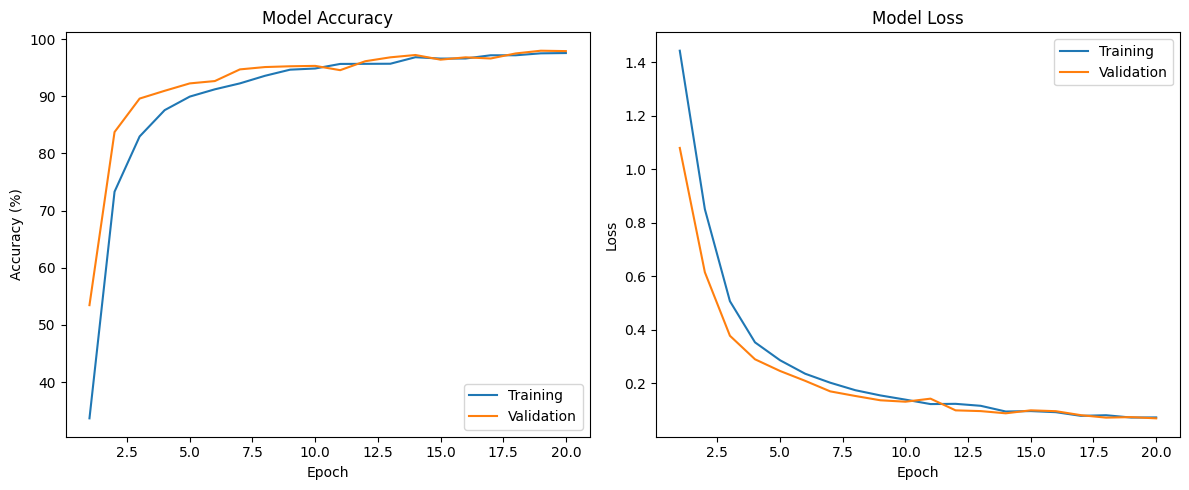


Measuring real-time performance metrics...

Real-time Performance Metrics:
Device: cpu
Average Inference Time: 0.31 ms
Std Dev Inference Time: 0.37 ms
Max Inference Time: 2.65 ms
95th Percentile Inference Time: 0.86 ms
Average Memory Usage: 647.77 MB
Peak Memory Usage: 647.77 MB

Final test accuracy: 95.18%


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded model weights to model_weights_20241209_002917.pth


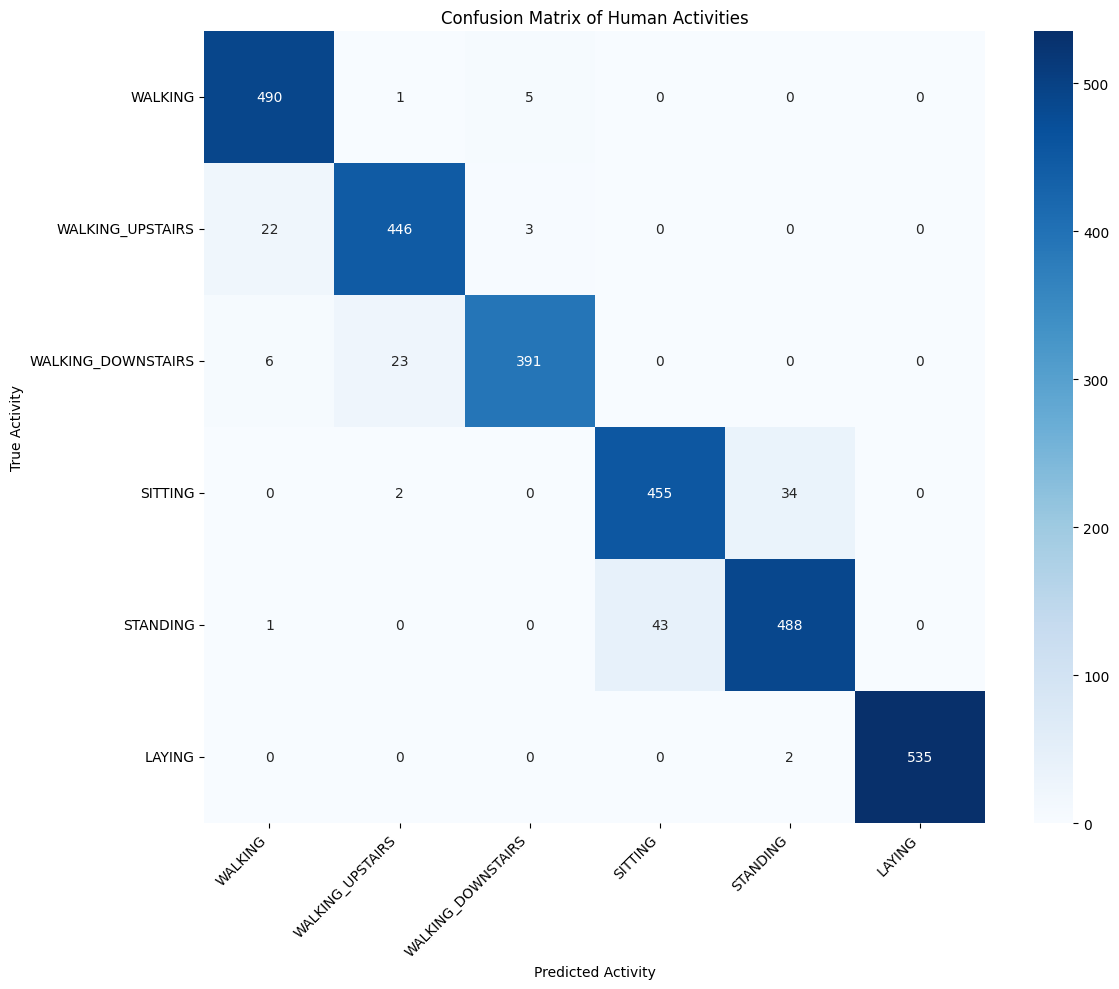

In [3]:


def set_seeds(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)

def create_model(input_features, hidden_size1, hidden_size2, dropout_rate, n_classes=6):
    return nn.Sequential(
        nn.Linear(input_features, hidden_size1),
        nn.ReLU(),
        nn.Dropout(dropout_rate),
        nn.Linear(hidden_size1, hidden_size2),
        nn.ReLU(),
        nn.Dropout(dropout_rate),
        nn.Linear(hidden_size2, n_classes)
    )

def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    return running_loss / len(train_loader), 100. * correct / total

def validate_model(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    return running_loss / len(val_loader), 100. * correct / total


def plot_training_metrics(train_losses, train_accs, val_losses, val_accs):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Plot losses
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_losses, label='Training')
    plt.plot(epochs, val_losses, label='Validation')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracies
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_accs, label='Training')
    plt.plot(epochs, val_accs, label='Validation')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()
def measure_inference_performance(model, X_test, device, n_runs=100):
    latencies = []
    memory_usage = []

    model.eval()
    with torch.no_grad():
        model(torch.FloatTensor(X_test[:1]).to(device))

    for _ in range(n_runs):
        process = psutil.Process()
        memory_usage.append(process.memory_info().rss / 1024 / 1024)

        start_time = time.time()
        with torch.no_grad():
            model(torch.FloatTensor(X_test[:1]).to(device))
        latencies.append((time.time() - start_time) * 1000)

        if device.type == 'cuda':
            torch.cuda.synchronize()

    metrics = {
        'avg_inference_time_ms': np.mean(latencies),
        'std_inference_time_ms': np.std(latencies),
        'max_inference_time_ms': np.max(latencies),
        'p95_inference_time_ms': np.percentile(latencies, 95),
        'avg_memory_usage_mb': np.mean(memory_usage),
        'peak_memory_usage_mb': np.max(memory_usage),
        'device': device.type
    }

    return metrics
def save_and_download_model_weights(model):

    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

    model_path = f'model_weights_{timestamp}.pth'
    torch.save(model.state_dict(), model_path)

    # Download the file
    files.download(model_path)
    print(f"Downloaded model weights to {model_path}")


set_seeds(42)


batch_size =  128

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train.ravel() - 1)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test.ravel() - 1)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Split training data
val_size = int(0.2 * len(train_dataset))
train_size = len(train_dataset) - val_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_subset, batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size)
test_loader = DataLoader(test_dataset, batch_size)

model = create_model(
    input_features = 561,
    hidden_size1 = 50,
    hidden_size2 = 20,
    dropout_rate = 0.01
).to(device)

# Initialize optimizer and criterion
optimizer = torch.optim.Adam(model.parameters(), weight_decay = 0.001, lr= 0.001)
criterion = nn.CrossEntropyLoss()

# Training loop
epochs = 20
train_losses = []
train_accs = []
val_losses = []
val_accs = []

print("Training final model...")
for epoch in range(epochs):
    # Train
    train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validate
    val_loss, val_acc = validate_model(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    if (epoch + 1) % 2 == 0:
        print(f"Epoch {epoch + 1}/{epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

# Plot training metrics
plot_training_metrics(train_losses, train_accs, val_losses, val_accs)


print("\nMeasuring real-time performance metrics...")
performance_metrics = measure_inference_performance(model, X_test, device)

print("\nReal-time Performance Metrics:")
print(f"Device: {performance_metrics['device']}")
print(f"Average Inference Time: {performance_metrics['avg_inference_time_ms']:.2f} ms")
print(f"Std Dev Inference Time: {performance_metrics['std_inference_time_ms']:.2f} ms")
print(f"Max Inference Time: {performance_metrics['max_inference_time_ms']:.2f} ms")
print(f"95th Percentile Inference Time: {performance_metrics['p95_inference_time_ms']:.2f} ms")
print(f"Average Memory Usage: {performance_metrics['avg_memory_usage_mb']:.2f} MB")
print(f"Peak Memory Usage: {performance_metrics['peak_memory_usage_mb']:.2f} MB")

# Evaluate on test set
test_loss, test_acc = validate_model(model, test_loader, criterion, device)
print(f"\nFinal test accuracy: {test_acc:.2f}%")

save_and_download_model_weights(model)

activities = [
    'WALKING',
    'WALKING_UPSTAIRS',
    'WALKING_DOWNSTAIRS',
    'SITTING',
    'STANDING',
    'LAYING'
]

# Create confusion matrix
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=activities,
            yticklabels=activities)

plt.title('Confusion Matrix of Human Activities')
plt.xlabel('Predicted Activity')
plt.ylabel('True Activity')

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

